In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def load_npy_image(file_path):
    """Load a .npy image file."""
    try:
        return np.load(file_path)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None  # Return None if loading fails

def resize_image(image, size=(224, 224)):
    """Resize an image to a given size."""
    resized_image = tf.image.resize(image, size)
    return resized_image.numpy()  # Convert to NumPy array after resizing

def normalize_image(image):
    """Normalize image values to range [0, 1]."""
    if image is not None:
        return image.astype(np.float32) / 255.0  # Normalize to [0, 1]
    return None

def load_and_preprocess_images(data_dir, num_samples=5):
    """Load and preprocess images for the inpainting task."""
    masked_files = sorted(
        [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith("masked_")]
    )
    
    images = []
    for i, file_path in enumerate(masked_files[:num_samples]):
        img = load_npy_image(file_path)
        print(img.shape)
        if img is not None:
            img = resize_image(img)
            img = normalize_image(img)
            images.append(img)
            # Check dimensions for compatibility
            check_image_dimensions(img)
        else:
            print(f"Skipping {file_path} due to loading error.")

    return images

def check_image_dimensions(image):
    """Check if the image has the correct dimensions."""
    if image.ndim != 3 or image.shape[-1] != 3:
        raise ValueError(f"Image dimensions are not compatible: {image.shape}. Expected shape: [height, width, 3]")

def display_images(images):
    """Display images in a grid."""
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


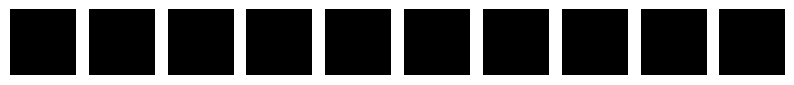

In [4]:
data_dir = r"F:\ssl_images\data\processed\coco\inpainting"  # Use raw string
images = load_and_preprocess_images(data_dir, 10)
display_images(images)


In [38]:
import tensorflow as tf
a = tf.io.read_file(r"F:\ssl_images\data\processed\coco\inpainting\masked_0.npy")


In [1]:
!pip install scikit-image


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.8 MB 11.1 MB/s eta 0:00:02
   ---- ----------------------------------- 1.3/12.8 MB 14.1 MB/s eta 0:00:01
   ------- -------------------------------- 2.4/12.8 MB 17.0 MB/s eta 0:00:01
   ------------ --------------------------- 3.9/12.8 MB 20.6 MB/s eta 0:00:01
   ------------------ --------------------- 5.8/12.8 MB 24.9 MB/s eta 0:00:01
   -------------------------- ------------- 8.6/12.8 MB 30.5 MB/s eta 0:00:01
   ----------------------------------- ---- 11.5/12.8 MB 43.5 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.8 MB 54.7 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 46.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/315.4 kB ? eta -:--:--
   --------------------------------------- 315.4/315.4 kB 19.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/228.2 kB ? eta -:--:--
  

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import tensorflow as tf
from tqdm import tqdm
import sys

#sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "..")))
from src.models.resnet import ResNet50, ResNet18

from skimage.color import rgb2lab, lab2rgb  # Import for color space conversion

def load_and_preprocess_image(image_path):
    """Load and preprocess a single image for colorization."""
    # Load image
    img = np.load(image_path)
    
    # Convert to float and normalize
    img = tf.cast(img, tf.float32) #/ 255.0
    
    # Ensure grayscale input
    if len(img.shape) == 3 and img.shape[-1] == 3:
        img = tf.image.rgb_to_grayscale(img)
    
    # Add batch dimension
    img = tf.expand_dims(img, 0)
    
    return img

def visualize_colorization(model_path, image_path):
    """Load model, process image, and visualize results."""
    # Initialize model
    model = ResNet18((224, 224, 1))
    
    # Load trained weights
    model.load_weights(model_path)
    
    # Load and preprocess input image
    input_image = load_and_preprocess_image(image_path)
    
    # Get model prediction
    predicted_color = model.predict(input_image)
    L, a, b = tf.unstack(predicted_color, axis=-1)
    
    # Scale L channel to [0, 1]
    L = L * 100.0
    
    # Scale a and b channels to [0, 1]
    a = (a * 255.0) - 128.0  # Scale a from [-128, 127] to [0, 1]
    b = (b * 255.0) - 128.0  # Scale b from [-128, 127] to [0, 1]
    
    # Stack channels back together
    predicted_color = tf.stack([L, a, b], axis=-1)
    predicted_color = lab2rgb(predicted_color)
    
    # Remove batch dimension
    input_image = tf.squeeze(input_image)
    predicted_color = tf.squeeze(predicted_color) #* 255.0
    
    # Load original color image for comparison
    color_path = image_path.replace('gray', 'color')
    original_color = np.load(color_path)
    #original_color = lab2rgb(original_color)
    original_color = lab2rgb(original_color)
    original_color = original_color.astype(np.float32)
    
    # Create figure with three subplots
    plt.figure(figsize=(15, 5))
    
    # Plot grayscale input
    plt.subplot(1, 3, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title('Grayscale Input')
    plt.axis('off')
    
    # Plot model prediction
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_color)
    plt.title('Model Colorization')
    plt.axis('off')
    
    # Plot original color image
    plt.subplot(1, 3, 3)
    plt.imshow(original_color)
    plt.title('Original Color')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    mae = tf.reduce_mean(tf.abs(original_color - predicted_color))
    mse = tf.reduce_mean(tf.square(original_color - predicted_color))
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Absolute Error: {mse:.4f}")


In [5]:
# Set up paths
model_path = os.path.join("models", "checkpoints", "model_epoch_024.h5")
data_dir = os.path.join("F:\\ssl_images\\data", "processed", "coco", 'colorization')

# Get a test image path (using the first grayscale image in the directory)
test_image = next(
    os.path.join(data_dir, f) 
    for f in os.listdir(data_dir) 
    if f.startswith("gray")
)
test_image = test_image.replace('0', '711')
print(test_image)

print("Running colorization inference...")
visualize_colorization(model_path, test_image)
print("Visualization complete!")

F:\ssl_images\data\processed\coco\colorization\gray711.npy
Running colorization inference...


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'models\checkpoints\model_epoch_024.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

(224, 224)
0.4990952


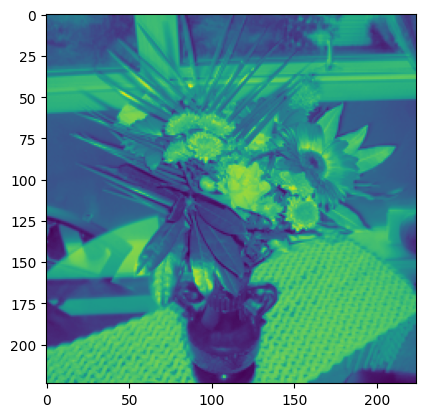

In [11]:
import os
def load_and_preprocess_image(image_path):
    """Load and preprocess a single image for colorization."""
    # Load image
    img = np.load(image_path)
    
    # Convert to float and normalize
    img = tf.cast(img, tf.float32) #/ 255.0

    
    # Add batch dimension
    img = tf.expand_dims(img, 0)
    
    return img

a = load_and_preprocess_image(os.path.join("F:\\ssl_images\\data", "processed", "coco", 'colorization', 'gray220.npy'))
a = tf.squeeze(a).numpy()
print(a.shape)
print(a.mean())
#print(lab2rgb(a).mean())
#plt.imshow(lab2rgb(a))
plt.imshow(a)

In [22]:
import tensorflow_io as tfio
import tensorflow as tf
class VGGPerceptualLoss(tf.keras.Model):
    def __init__(self, resize_inputs=True):
        super().__init__()
        # Load VGG19 pretrained on ImageNet
        vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
        vgg.trainable = False

        # We'll use these activation layers for perceptual loss
        output_layers = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]

        outputs = [vgg.get_layer(name).output for name in output_layers]
        self.model = tf.keras.Model([vgg.input], outputs)
        self.resize_inputs = resize_inputs

    def call(self, inputs):
        # Preprocessing for VGG
        x = tf.keras.applications.vgg19.preprocess_input(inputs * 255.0)
        return self.model(x)


class ColorizationLoss(tf.keras.losses.Loss):
    def __init__(self, vgg_weight=1.0, l1_weight=1.0):
        super().__init__()
        self.vgg_model = VGGPerceptualLoss()
        self.mae = tf.keras.losses.MeanAbsoluteError()
        self.vgg_weight = vgg_weight
        self.l1_weight = l1_weight
    
    @staticmethod
    def inverse_scale_output(batch):
        # Ensure the batch has the expected shape
        if batch.shape[-1] != 3:
            raise ValueError(f"Expected batch to have 3 channels, got {batch.shape[-1]}")

        # Split the batch into L, a, and b channels
        L, a, b = tf.unstack(batch, 3, axis=-1)

        # Scale and shift channels using broadcasting
        L = L * 100.0
        a = (a * 255.0) - 128.0
        b = (b * 255.0) - 128.0

        # Combine channels using broadcasting
        return tf.stack([L, a, b], axis=-1)

    @staticmethod
    def lab_to_rgb(lab):
        """Convert LAB to RGB color space using TensorFlow operations."""
        # Efficient LAB to RGB conversion using TensorFlow's built-in functions
        lab = tf.image.convert_image_dtype(lab, dtype=tf.float32)
        rgb = tf.image.convert_image_dtype(tfio.experimental.color.lab_to_rgb(lab), dtype=tf.float32)
        return tf.image.convert_image_dtype(rgb, dtype=tf.float32)
        #return tf.py_function(func=lab2rgb, inp=[lab], Tout=tf.float32)
        
    def call(self, y_true, y_pred):
        # Ensure inputs have correct shape and data type
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # L1 loss in LAB space
        l1_loss = self.mae(y_true, y_pred)

        # Convert LAB to RGB for perceptual loss
        y_true_rgb = self.lab_to_rgb(self.inverse_scale_output(y_true))
        y_pred_rgb = self.lab_to_rgb(self.inverse_scale_output(y_pred))

        # VGG perceptual loss in RGB space
        vgg_true = self.vgg_model(y_true_rgb)
        vgg_pred = self.vgg_model(y_pred_rgb)

        perceptual_loss = 0.0
        for pt, pp in zip(vgg_true, vgg_pred):
            perceptual_loss += tf.reduce_mean(tf.square(pt - pp))

        # Combine losses
        total_loss = (self.l1_weight * l1_loss) + (self.vgg_weight * perceptual_loss)
        return total_loss
loss_fn = ColorizationLoss()

In [23]:
def unscale(x):
    L, a, b = tf.unstack(x, axis=-1)

    # Scale L channel to [0, 1]
    L = L * 100.0

    # Scale a and b channels to [0, 1]
    a = (a * 255.0) - 128.0  # Scale a from [-128, 127] to [0, 1]
    b = (b * 255.0) - 128.0  # Scale b from [-128, 127] to [0, 1]

    # Stack channels back together
    return tf.stack([L, a, b], axis=-1)

def scale(x):
    L, a, b = tf.unstack(x, axis=-1)

    # Scale L channel to [0, 1]
    L = L / 100.0

    # Scale a and b channels to [0, 1]
    a = (a + 128.0) / 255.0  # Scale a from [-128, 127] to [0, 1]
    b = (b + 128.0) / 255.0  # Scale b from [-128, 127] to [0, 1]

    # Stack channels back together
    return tf.stack([L, a, b], axis=-1)

In [24]:
#for i in range(1, 1000):
i = 23
image_path = os.path.join("F:\\ssl_images\\data", "processed", "coco", 'colorization', f'gray{i}.npy')
"""Load model, process image, and visualize results."""
# Initialize model
model = ResNet18((224, 224, 1))

# Load trained weights
#model.load_weights(os.path.join("models", "checkpoints", "model_epoch_012.h5"))

# Load and preprocess input image
input_image = load_and_preprocess_image(image_path)

# Get model prediction
y_pred = model.predict(input_image)

# Stack channels back together
predicted_color = unscale(y_pred)
predicted_color = lab2rgb(predicted_color)

# Remove batch dimension
input_image = tf.squeeze(input_image)
predicted_color = tf.squeeze(predicted_color)

# Load original color image for comparison
color_path = image_path.replace('gray', 'color')
y_true = np.load(color_path)
original_color = lab2rgb(y_true)
y_true = scale(y_true)
original_color = original_color.astype(np.float32)
print(loss_fn(tf.expand_dims(y_true, 0), y_pred))


1/1 [==============================] - 1s 652ms/step
tf.Tensor(355358.4, shape=(), dtype=float32)


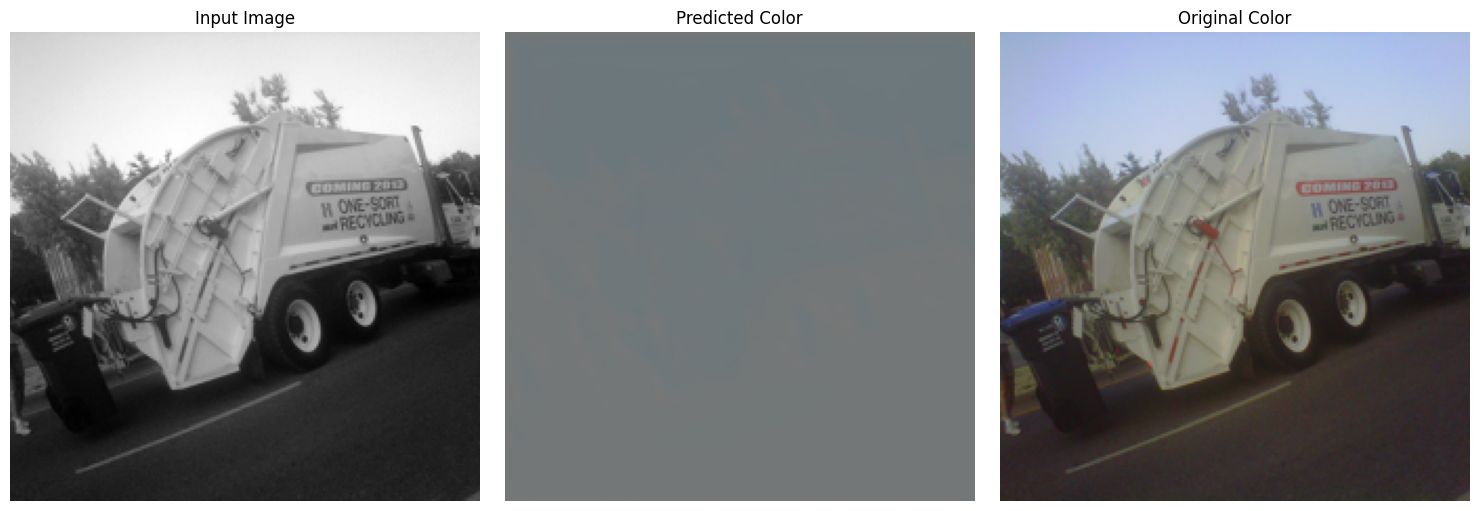

In [25]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Display the images
axs[0].imshow(input_image, cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')  # Hide axes

axs[1].imshow(predicted_color)
axs[1].set_title('Predicted Color')
axs[1].axis('off')  # Hide axes

axs[2].imshow(original_color)
axs[2].set_title('Original Color')
axs[2].axis('off')  # Hide axes

# Show the plot
plt.tight_layout()
plt.show()


In [3]:
from src.models.resnet import ResNet18, ResNet50  # Import your ResNet implementation

model = ResNet18((224, 224, 3))
model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 64)         9472      ['input_3[0][0]']             
                                                                                                  
 bn1 (BatchNormalization)    (None, 112, 112, 64)         256       ['conv1[0][0]']               
                                                                                                  
 leaky_re_lu_34 (LeakyReLU)  (None, 112, 112, 64)         0         ['bn1[0][0]']                 
                                                                                           